# Chapter03 분류

In [1]:
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import pandas as pd

MNIST 데이터셋

In [2]:
# MNIST 데이터셋을 내려받는 코드

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']
print(X.shape)  # 784=28*28, 이미지
print(y.shape)  # 타깃값

(70000, 784)
(70000,)


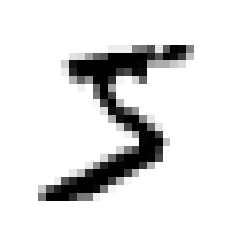

In [4]:
some_digit = X[0]   # 첫 번째 샘플
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [5]:
y[0]   # 첫 번째 샘플의 타깃값

'5'

In [6]:
y = y.astype(np.uint8)  # y를 정수로 변환

In [7]:
# (잘 섞여진 데이터) 훈련세트, 테스트세트로 나누기
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### 3.2 이진 분류기 훈련

단순화해서 5인지 아닌지를 구분하는 '5-감지기'를 만들어보자

In [8]:
# 5이면 True, 아니면 False
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
# 확률적경사하강법 (SGD) 분류기로 훈련
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [10]:
sgd_clf.predict([some_digit])   # 훈련한 SGD모델로 첫 번째 샘플 예측

# True (5가 맞음)으로 예측

array([ True])

### 3.3 성능 측정

교차검증으로 정확도 측정

In [11]:
# 교차 검증 구현  (cross_val_score()함수와 거의 같음)
from sklearn.model_selection import StratifiedKFold    # 계층적 샘플링이 적용된 K-폴드
from sklearn.base import clone#  동일한 모수를 사용하여 새로운 적합하지 않은 추정량을 생성함

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

# X_train을 y_train_5 의 클래스별 비율이 유지되도록 폴드를 만듦
for train_index, test_index in skfolds.split(X_train, y_train_5):  # train_index: 훈련세트
    clone_clf = clone(sgd_clf)                                     # test_index:  검증세트
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)  # 훈련세트에서 훈련
    y_pred = clone_clf.predict(X_test_fold)      # 검증세트에서 예측
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [13]:
# 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기

# 사이킷런의 BaseEsimators를 활용하면 Customized된 Estimator 생성 가능
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)   # 모두 '5가 아니다'라고 예측

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

더미 분류기를 사용했음에도 불구하고 정확도가 높게 나옴 --> 성능 측정 지표로 정확도는 부적절하다!!

---

- 오차 행렬 :
 
 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것

![image.jpg](http://jcsites.juniata.edu/faculty/rhodes/ml/images/confmat)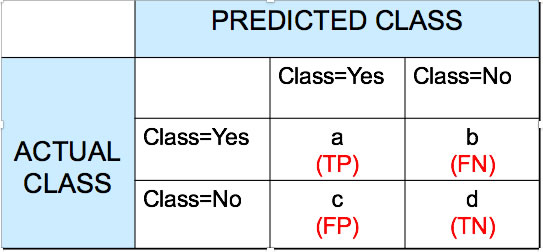

In [15]:
# 실제 타깃값과 비교할 수 있는 예측값 만들기
from sklearn.model_selection import cross_val_predict

# 각 검증 폴드에서 얻은 예측 반환
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
# 오차 행렬 만들기
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

- 행 : 실제 클래스

- 열 : 예측한 클래스

 첫 번째 : 음성 클래스, 두 번째 : 양성 클래스

정밀도 (precision) = $\frac{TP}{TP + FP}$ : 양성으로 예측한 것중 진짜 양성의 비율

재현율 (recall) = $\frac{TP}{TP + FN}$ : 실제 양성인 것중 제대로 예측한 것의 비율

( $TP$ : 진짜 양성, $TN$ : 진짜 음성, $FP$ : 거짓 양성, $FN$ : 거짓 음성 )

In [17]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))  # 정밀도
print(recall_score(y_train_5, y_train_pred))     # 재현율

0.8370879772350012
0.6511713705958311


- F1 점수 : 정밀도와 재현율의 조화 평균

 $F1 = \frac{2}{\frac{1}{정밀도}+ \frac{1}{재현율}}$

 정밀도와 재현율이 비슷한 분류기에서는 F1 점수가 높다.

 하지만 상황에 따라 정밀도와 재현율의 중요도가 다를 수 있다.

In [18]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

정밀도 / 재현율 트레이드오프

**결정 함수** (decision function) 로 각 샘플의 점수를 계산하여 점수가 임곗값보다 크면 양성클래스로, 작으면 음성클래스에 할당

- 결정 임곗값을 높이면 : 재현율↓ , 정밀도↑

- 결정 임곗값을 내리면 : 재현율↑ , 정밀도↓

In [19]:
y_scores = sgd_clf.decision_function([some_digit])  # 해당 샘플의 결정함수
y_scores

array([2164.22030239])

In [28]:
threshold = 0  # 임곗값 지정
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [30]:
threshold = 4000   # 임곗값을 올려보자
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

적절한 임곗값 구하기

In [31]:
# 우선 cross_val_predict()로 훈련 세트에 있는 결정함수를 구한다.
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [33]:
# precision_recall_curve()로 가능한 모든 임곗값에 대해 정밀도와 재현율을 계산할 수 있다
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds =  precision_recall_curve(y_train_5, y_scores)

0.4799852425751706 3370.0194991439557


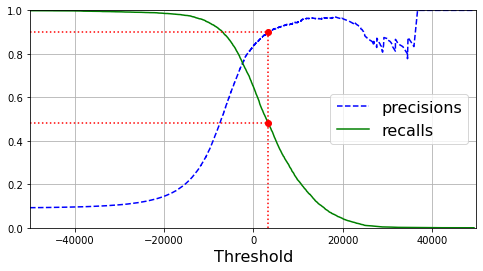

In [76]:
# 임곗값의 함수로 정밀도와 재현율을 그려보자
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precisions')
    plt.plot(thresholds, recalls[:-1], 'g-', label='recalls')
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

# np.argmax() : 최댓값의 첫 번째 인덱스를 반환
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]       # precisions가 0.9 보다 크게 하는 최대한의 recalls로 지정
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # precisions를 0.9 보다 크게 하는 최소한의 임곗값으로 지정

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")       # 빨간 세로줄
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                      # 빨간 가로줄 위에꺼
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:") # 빨간 가로줄 밑에꺼
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")

plt.show()

In [78]:
(y_train_pred == (y_scores > 0)).all()  # all(): 모두 True이면 True, 하나라도 False가 있으면 False

# y_scores가 0보다 크면 모두 5라고 예상

True

정밀도 90%를 달성하는 것이 목표라고 가정해보자.

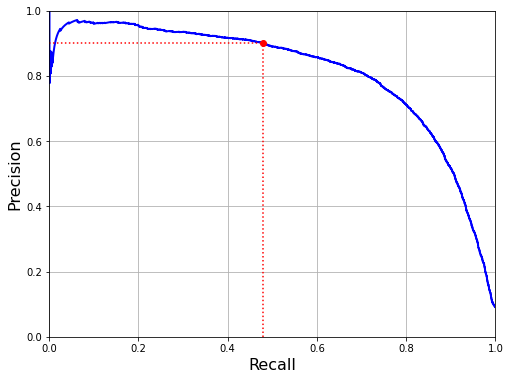

In [86]:
# 재현율에 대한 정밀도 곡선 (PR 곡선)
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")

plt.show()

- 재현율 80% 근처에서 정밀도가 급격히 줄기 시작하는데, 이 하강점 직전을 ' 정밀도 / 재현율 트레이드오프 ' 로 선택하는 것이 좋다.

- 그래프 아래의 면적이 클수록 좋은 그래프이다.

In [87]:
# threshold_90_precision : 정밀도를 0.90 보다 크게 하는 최소한의 임곗값

y_train_pred_90 = (y_scores >= threshold_90_precision)

In [93]:
print(f"정밀도: {precision_score(y_train_5, y_train_pred_90)}")  # 정밀도 계산
print(f"재현율: {recall_score(y_train_5, y_train_pred_90)}")     # 재현율 계산

정밀도: 0.9000345901072293
재현율: 0.4799852425751706


정밀도 90%를 달성한 분류기를 만들었다

- 정밀도와 재현율에 대해서 분류기를 만들려면 임곗값을 조정하면 된다!!

---

- 수신기 조작 특성 ( **ROC** ) 곡선 : $\frac{TP \space(재현율)}{FPR}$

 $FPR = \frac{FP}{FP + TN}$ : 실제 음성 중, 양성으로 예측한 비율

 $TPR = \frac{TP}{TP + FN}$ : 실제 양성 중, 음성으로 예측한 비율 (== 재현율)

In [94]:
# 여러 임곗값에서 TPR, FPR을 계산해주는 메서드
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)   # 매개변수에 타깃값, 예측값을 전달

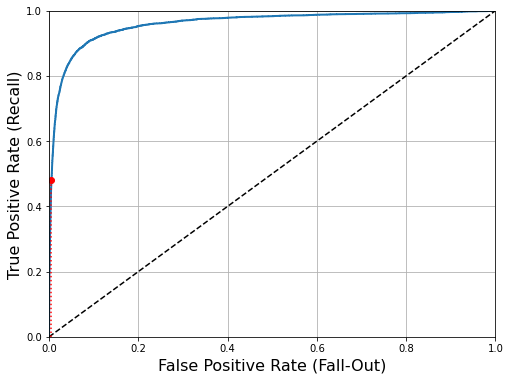

In [101]:
# ROC (TPR에 대한 FPR) 곡선을 그려주는 메서드 정의
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')   # 대각 점선 그리기
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]   # fpr_90 : tpr이 정밀도가 최소 90% 되는 재현율보다 큰거중에 최소의 fpr
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r
plt.plot([fpr_90], [recall_90_precision], "ro")

plt.show()

# 빨간 점은 최소 90%의 정밀도를 가진 재현율을 뜻함

재현율(TPR)이 높을수록 FPR이 늘어난다.

점선은 완전한 랜덤 분류기 (더미 분류기)의 ROC 곡선을 의미한다.

좋은 분류기는 이 점선에서 최대한 멀리 떨어져 있어야 한다. (왼쪽 위 모서리)

- --> 곡선 아래의 면적 (AUC) : Area Under the Curve 을 측정하면 분류기들을 비교할 수 있다!!
 
 완벽한 분류기는 AUC가 1이고, 완전한 랜덤분류기의 AUC는 0.5이다.


In [102]:
# 사이킷런의 ROC의 AUC를 계산하는 함수
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)  # 매개변수에 타깃값, 예측값을 전달

# 1 에 가까울수록 좋은 분류기이다

0.9604938554008616

RandomForestClassifier를 훈련시켜 SGDClassifier의 ROC곡선과 AUC를 비교해보자

In [103]:
# 우선, 훈련 세트에 대한 점수를 얻는다
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')
# 각 샘플마다 [음성일 확률, 양성일 확률] 반환

In [128]:
y_probas_forest[35]  # [음성일 확률, 양성일 확률] 반환

array([0.07, 0.93])

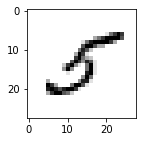

In [130]:
plt.figure(figsize=(2,2))
plt.imshow(X_train[35].reshape(28,28), cmap='gray_r')
plt.show()

In [131]:
y_scores_forest = y_probas_forest[:, 1]  # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

0.9511160302527208 0.4799852425751706 0.005295076861063779


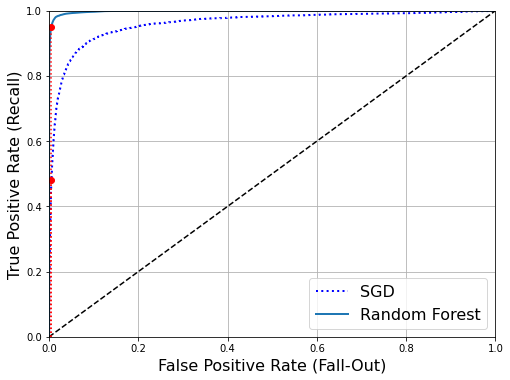

In [145]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]
print(recall_for_forest, recall_90_precision, fpr_90)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)

plt.show()

RandomForest분류기가 SGD분류기보다 AUC 값이 크므로 더 좋은 모델이다!

- 임곗값에 따라 빨간점의 위치가 달라지고, 모델의 성능에 따라 ROC곡선의 휨 정도가 달라진다.

In [159]:
print(f"랜덤포레스트 분류기 AUC : {roc_auc_score(y_train_5, y_scores_forest)}")
print(f"SGD 분류기 AUC :\t  {roc_auc_score(y_train_5, y_scores)}")

랜덤포레스트 분류기 AUC : 0.9983436731328145
SGD 분류기 AUC :	  0.9604938554008616


In [160]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
print("Random Forest 분류기의 정밀도와 재현율")
print(f"정밀도: {precision_score(y_train_5, y_train_pred_forest)}")
print(f"재현율: {recall_score(y_train_5, y_train_pred_forest)}")

Random Forest 분류기의 정밀도와 재현율
정밀도: 0.9905083315756169
재현율: 0.8662608374838591


### 3.4 다중 분류

SGD, randomforest 등의 분류기는 다중 분류가 가능하지만 로지스틱 회귀나 서포트 벡터 머신 분류기같은 알고리즘은 이진 분류만 가능하다.

- OvR(OvA) : one-versus-the rest, 클래스마다 이진 분류기를 만들어서 가장 높은 결정점수를 낸 클래스를 선택

- OvO : one-versus-one, 모든 가능한 두 개의 클래스 조합 $\frac{n(n-1)}{2}$에 대해 이진 분류기를 만듦. 가장 많이 양성으로  분류된 클래스 선택

다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면 사이킷런이 알고리즘에 따라 자동으로 OvR 또는 OvO를 실행한다.

In [161]:
# 서포트 벡터 머신 분류기 테스트
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])   # 첫 번째 샘플 예측

array([5], dtype=uint8)

사이킷런 내부에서 OvO로, 45개의 이진분류기를 훈련 후 각각의 결정점수로 가장 높은 클래스 선택한다.

In [163]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])